# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Para Aplicações de IA com PyTorch e Lightning</font>

## <font color='blue'>Estudo de Caso 2</font>
## <font color='blue'>Os Efeitos dos Processos de Inicialização e Otimização</font>

![title](imagens/EC2.png)

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# !pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
# !pip install -q -U watermark

In [3]:
!pip install -q torch==1.13.0

In [4]:
!pip install -q torchvision==0.14.0

In [5]:
# Imports
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import models
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib
import gc
import types
import pkg_resources
import pytorch_lightning as pl
%matplotlib inline

In [6]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

Author: Data Science Academy

pytorch_lightning: 1.9.3
numpy            : 1.21.5
torchvision      : 0.14.0
matplotlib       : 3.5.2
torch            : 1.13.0



## Verificando o Ambiente de Desenvolvimento

In [7]:
# Relatório completo

# Verificando o dispositivo
processing_device = "cuda" if torch.cuda.is_available() else "cpu"

# Verificando se GPU pode ser usada (isso depende da plataforma CUDA estar instalada)
torch_aval = torch.cuda.is_available()

# Labels para o relatório de verificação
lable_1 = 'Visão Geral do Ambiente'
lable_2 = 'Se NVIDIA-SMI não for encontrado, então CUDA não está disponível'
lable_3 = 'Fim da Checagem'

# Função para verificar o que está importado nesta sessão
def get_imports():

    for name, val in globals().items():
        if isinstance(val, types.ModuleType):
            name = val.__name__.split(".")[0]

        elif isinstance(val, type):            
            name = val.__module__.split(".")[0]

        poorly_named_packages = {"PIL": "Pillow", "sklearn": "scikit-learn"}

        if name in poorly_named_packages.keys():
            name = poorly_named_packages[name]

        yield name

# Imports nesta sessão
imports = list(set(get_imports()))

# Loop para verificar os requerimentos
requirements = []
for m in pkg_resources.working_set:
    if m.project_name in imports and m.project_name!="pip":
        requirements.append((m.project_name, m.version))
        
# Pasta com os dados (quando necessário)
pasta_dados = r'dados'

print(f'{lable_1:-^100}')
print()
print(f"Device:", processing_device)
print(f"Pasta de Dados: ", pasta_dados)
print(f"Versões dos Pacotes Requeridos: ", requirements)
print(f"Dispositivo Que Será Usado Para Treinar o Modelo: ", processing_device)
print(f"CUDA Está Disponível? ", torch_aval)
print("Versão do PyTorch: ", torch.__version__)
print("Versão do Lightning: ", pl.__version__)
print()
print(f'{lable_2:-^100}\n')
!nvidia-smi
gc.collect()
print()
print(f"Limpando a Memória da GPU (se disponível): ", torch.cuda.empty_cache())
print(f'\n{lable_3:-^100}')

--------------------------------------Visão Geral do Ambiente---------------------------------------

Device: cuda
Pasta de Dados:  dados
Versões dos Pacotes Requeridos:  [('matplotlib', '3.5.2'), ('numpy', '1.21.5'), ('torch', '1.13.0'), ('torchvision', '0.14.0')]
Dispositivo Que Será Usado Para Treinar o Modelo:  cuda
CUDA Está Disponível?  True
Versão do PyTorch:  1.13.0+cu117
Versão do Lightning:  1.9.3

------------------Se NVIDIA-SMI não for encontrado, então CUDA não está disponível------------------

Tue Feb 28 16:11:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.78.01    Driver Version: 525.78.01    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                     

## Funções Auxiliares Para Colocar os Dados no Dispositivo de Treino (GPU ou CPU)

In [8]:
# Função para obter o device
# Se disponível usamos GPU. Caso contrário usamos CPU.
def get_default_device():
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [9]:
# Função para enviar um tensor para o device
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking = True)

In [10]:
# Classe para enviar os dataloaders para o device
class DeviceDataLoader():

    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        return len(self.dl)

In [11]:
device = get_default_device()

In [12]:
device

device(type='cuda')

## Pré-Processamento dos Dados

Vamos realizar as tarefas de pré-processamento dos dados (neste caso das imagens) e então carregar os dados.

> Aqui nós preparamos as transformações dos dados.

In [13]:
# Estatísticas de normalização (médias e desvios para cada canal de cor)
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [14]:
# Define as Transformações 
transforms = transforms.Compose([transforms.RandomCrop(64, padding = 4, padding_mode = 'reflect'), 
                                 transforms.Resize(64),
                                 transforms.RandomHorizontalFlip(), 
                                 transforms.ToTensor(), 
                                 transforms.Normalize(*stats, inplace = True)])

> Aqui nós carregamos os dados do disco e aplicamos as transformações. 

In [15]:
dados_treino = datasets.ImageFolder("dados/treino", transform = transforms)

In [16]:
dados_valid = datasets.ImageFolder("dados/val", transform = transforms)

In [17]:
dados_teste = datasets.ImageFolder("dados/teste", transform = transforms)

In [18]:
print(f"Número Total de Imagens de Treino: {len(dados_treino)}")
print(f"Número Total de Imagens de Validação: {len(dados_valid)}")
print(f"Número Total de Imagens de Teste: {len(dados_teste)}") 

Número Total de Imagens de Treino: 3941
Número Total de Imagens de Validação: 845
Número Total de Imagens de Teste: 845


> Aqui preparamos os data loaders.

https://developer.nvidia.com/blog/how-optimize-data-transfers-cuda-cc/

In [19]:
# Parâmetros para os dataloaders
batch_size = 8
shuffle = True
num_workers = 2
pin_memory = True

In [20]:
# Data loader de treino
data_loader_treino = DataLoader(dados_treino, 
                                batch_size, 
                                shuffle = shuffle, 
                                num_workers = num_workers, 
                                pin_memory = pin_memory)

In [21]:
# Data loader de validação
data_loader_valid = DataLoader(dados_valid, 
                               batch_size, 
                               num_workers = num_workers, 
                               pin_memory = pin_memory)

In [22]:
# Data loader de teste
data_loader_teste = DataLoader(dados_teste, 
                               batch_size * 2, 
                               num_workers = num_workers, 
                               pin_memory = pin_memory)

> Aqui visualizamos uma amostra dos dados.

In [23]:
# Função para "desnormalizar" os dados
def denormalize(images, means, stds):
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

In [24]:
# Função para imprimir um batch de dados
def mostra_dados(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize = (12, 12))
        ax.set_xticks([]); ax.set_yticks([])
        denorm_images = denormalize(images, *stats)
        ax.imshow(make_grid(denorm_images[:64], nrow = 8).permute(1, 2, 0).clamp(0,1))
        break

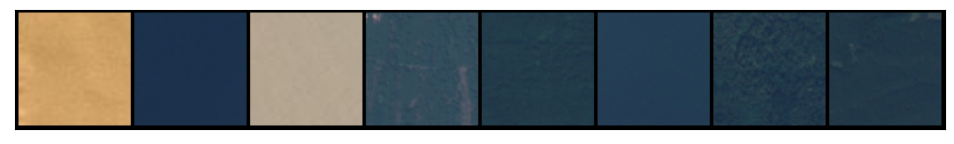

In [25]:
mostra_dados(data_loader_treino)

## Arquitetura do Modelo

In [26]:
# Função para calcular a acurácia
def accuracy(outputs, labels):
    
    # Extrai o maior valor dos outputs (classe com maior probabilidade)
    _, preds = torch.max(outputs, dim = 1)
    
    # Retorna a acurácia comparando as previsões com os valores reais
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

A arquitetura de Rede Neural Convolucional (CNN - Convolutional Neural Network) é um tipo de modelo de rede neural projetado para processar dados que têm uma estrutura de grade, como imagens. A estrutura da CNN é inspirada na organização do córtex visual do cérebro humano, que tem neurônios que respondem a regiões específicas do campo visual.

Uma CNN é composta por uma série de camadas, cada uma das quais executa uma operação específica na entrada de dados. As camadas típicas incluem:

Camadas de convolução: Essas camadas aplicam filtros a pequenas regiões da entrada, de modo a extrair características visuais importantes, como bordas, texturas e formas.

Camadas de pooling: Essas camadas reduzem o tamanho da representação da entrada, mantendo as características mais importantes. Isso ajuda a reduzir a complexidade do modelo e a aumentar a eficiência computacional.

Camadas totalmente conectadas: Essas camadas são semelhantes às camadas usadas em redes neurais padrão. Eles recebem as características extraídas pelas camadas anteriores e as usam para gerar uma saída.

As camadas são organizadas em uma topologia específica que é projetada para extrair características relevantes da entrada e classificar a imagem corretamente. Essa topologia pode variar dependendo da tarefa específica, como classificação de imagem, detecção de objeto, segmentação de imagem, entre outras.

As CNNs são amplamente utilizadas em tarefas relacionadas a imagens, como classificação, detecção de objeto, reconhecimento facial, entre outras. Seu sucesso em muitas dessas tarefas se deve em grande parte à sua capacidade de aprender representações hierárquicas de características visuais relevantes, tornando-as muito eficientes para lidar com grandes volumes de dados de imagem.

Funções de inicialização dos pesos:

https://pytorch.org/docs/stable/nn.init.html

nn.init.kaiming_uniform_ é uma função de inicialização de pesos do PyTorch que implementa a técnica de inicialização He uniforme, proposta por He et al. em 2015.

A inicialização He uniforme é uma técnica popular de inicialização de pesos que é usada comumente em redes neurais que usam ativações ReLU. A ideia por trás dessa técnica é que a inicialização aleatória dos pesos deve ser feita de tal maneira que a saída de cada camada tenha aproximadamente a mesma variância da entrada. Isso evita o problema de gradientes explodindo ou desaparecendo que pode ocorrer em redes neurais profundas.

O argumento mode na função nn.init.kaiming_uniform_() especifica qual dos dois valores deve ser usado no denominador da equação: fan_in ou fan_out. O valor padrão para o argumento mode é fan_in, que significa que o denominador da equação será definido como o número de entradas para a camada.

In [27]:
# Classificador Base
class ImageClassificationBase(nn.Module):
    
    # Método construtor
    def __init__(self):
        super().__init__()
        self.reset_parameters()
        
    # Método de resert dos pesos (parâmetros)
    def reset_parameters(self):
        self.weight = torch.empty(3, 4)
        nn.init.kaiming_uniform_(self.weight, mode = 'fan_in', nonlinearity = 'relu')
    
    # Método para o passo de treino
    def training_step(self, batch):
        
        # Recebe um batch
        images, labels = batch 
        
        # Faz uma previsão
        out = self(images)    
        
        # Calcula o erro
        loss = F.cross_entropy(out, labels) 
        
        return loss
    
    # Método para o passo de validação
    def validation_step(self, batch):
        
        # Recebe um batch
        images, labels = batch 
        
        # Faz uma previsão
        out = self(images)    
        
        # Calcula o erro
        loss = F.cross_entropy(out, labels)   
        
        # Calcula a acurácia
        acc = accuracy(out, labels)     
        
        return {'erro_valid': loss.detach(), 'acc_valid': acc}
        
    # Método para o passo de validação ao final de uma época
    def validation_epoch_end(self, outputs):
        batch_losses = [x['erro_valid'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['acc_valid'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'erro_valid': epoch_loss.item(), 'acc_valid': epoch_acc.item()}
    
    # Método para o fim de cada época
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, erro_treino: {:.4f}, erro_valid: {:.4f}, acc_valid: {:.4f}".format(
            epoch, result['lrs'][-1], result['erro_treino'], result['erro_valid'], result['acc_valid']))

A arquitetura ResNet (Residual Network) é uma arquitetura de Rede Neural Convolucional (CNN) desenvolvida pela Microsoft Research em 2015. É uma arquitetura profunda que se destaca por suas conexões residuais, que permitem que as informações fluam diretamente das camadas de entrada para as camadas de saída, contornando as camadas intermediárias. Isso ajuda a prevenir o problema de desvanecimento de gradientes, que é comum em redes muito profundas e pode dificultar o treinamento.

A ResNet consiste em várias camadas de convolução e normalização, seguidas por blocos residuais. Cada bloco residual é composto por várias camadas convolucionais e normalização, que são seguidas por um caminho residual. O caminho residual consiste em uma conexão direta da entrada do bloco à saída do bloco, o que permite que as informações fluam diretamente da entrada para a saída, sem passar por todas as camadas intermediárias.

A ResNet é conhecida por sua capacidade de criar modelos muito profundos e poderosos, com um número muito grande de camadas. Por exemplo, a ResNet-152 tem 152 camadas e ainda assim pode ser treinada com sucesso em tarefas de reconhecimento de imagem.

A arquitetura ResNet tem sido usada com sucesso em várias tarefas relacionadas a imagens, como classificação de imagens, detecção de objetos, segmentação de imagens, entre outras. Ela é considerada uma das arquiteturas mais influentes e eficazes em tarefas de visão computacional, tendo ganhado várias competições de reconhecimento de imagem, como o ImageNet Large Scale Visual Recognition Challenge (ILSVRC).

In [28]:
# Bloco de convolução
def conv_block(in_channels, out_channels, pool = False):
    
    # Camadas
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding = 1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace = True)]
    
    # Se pool = True, adiciona a camada de MaxPooling
    if pool: 
        layers.append(nn.MaxPool2d(2))
        
    return nn.Sequential(*layers)

In [29]:
# Arquitetura ResNet
class ResNet(ImageClassificationBase):
    
    # Método construtor
    def __init__(self, in_channels, num_classes):
        
        # Inicializa o construtor da classe mãe
        super().__init__()
        
        # Conv1
        self.conv1 = conv_block(in_channels, 64)
        
        # Conv2
        self.conv2 = conv_block(64, 128, pool = True)
        
        # Sequência de convs
        self.res1 = nn.Sequential(conv_block(128, 128), conv_block(128, 128))
        
        # Conv3
        self.conv3 = conv_block(128, 256, pool = True)
        
        # Conv4
        self.conv4 = conv_block(256, 512, pool = True)
        
         # Sequência de convs
        self.res2 = nn.Sequential(conv_block(512, 512), conv_block(512, 512))
        
        # Camada de classificação
        self.classifier = nn.Sequential(nn.AdaptiveMaxPool2d(1), 
                                        nn.Flatten(), 
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
    
    # Método forward
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [30]:
# Cria o objeto do modelo considerando 3 canais de cores nas imagens e 4 classes de saída
modelo = to_device(ResNet(3, 4), device)

In [31]:
modelo

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tru

> Enviamos os dataloaders para o device.

In [32]:
data_loader_treino = DeviceDataLoader(data_loader_treino, device)

In [33]:
data_loader_valid = DeviceDataLoader(data_loader_valid, device)

In [34]:
data_loader_teste = DeviceDataLoader(data_loader_teste, device)

## Funções Para o Loop de Treinamento

Criaremos aqui 3 funções para auxiliar no treinamento do modelo. Começamos com a função de avaliação.

In [35]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

@torch.no_grad() é um decorador usado no PyTorch para desativar o rastreamento de gradientes durante uma passagem de inferência ou validação em um modelo treinado.

Quando um modelo é treinado, o PyTorch mantém o rastreamento dos gradientes dos tensores para atualizar os pesos do modelo durante o processo de treinamento. No entanto, durante o processo de inferência ou validação, não precisamos atualizar os pesos do modelo e, portanto, não precisamos manter o rastreamento dos gradientes.

Ao usar o decorador @torch.no_grad(), podemos desativar o rastreamento de gradientes durante a inferência ou validação de um modelo treinado, reduzindo o uso de memória e aumentando a velocidade de cálculo.

In [36]:
# Função para obter a taxa de aprendizado
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [37]:
# Função de treino
def treina_modelo(epochs, 
                  max_lr, 
                  model, 
                  train_loader, 
                  val_loader, 
                  weight_decay = 0, 
                  grad_clip = None, 
                  opt_func = torch.optim.SGD):
    
    # Limpa o cache da GPU
    torch.cuda.empty_cache()
    
    # Lista para o histórico de treino
    history = []
    
    # Define o otimizador com a função opt_func
    if opt_func == torch.optim.Adam:
        optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay)
    elif opt_func == torch.optim.SGD:
        optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay, momentum = 0.9)
    elif opt_func == torch.optim.RMSprop:
        optimizer = opt_func(model.parameters(), max_lr, weight_decay = weight_decay, eps = 1e-9)
    
    # Configura o agendador de taxa de aprendizado de um ciclo
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr, 
                                                epochs = epochs, 
                                                steps_per_epoch = len(train_loader))
    
    # Loop de treino
    for epoch in range(epochs):
        
        # Coloca o modelo em modo de treino
        model.train()
        
        # Listas de controle
        train_losses = []
        lrs = []
        
        # Loop para extrair os batches
        for batch in train_loader:
            
            # Passo de treino
            loss = model.training_step(batch)
            
            # Armazena o erro
            train_losses.append(loss)
            
            # Backpropagation para calcular os gradientes
            loss.backward()
            
            # Gradient clipping 
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            # Passo de otimização
            optimizer.step()
            
            # Zera os gradientes
            optimizer.zero_grad()
            
            # Registra e atualiza a taxa de aprendizado
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validação
        result = evaluate(model, val_loader)
        result['erro_treino'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
        
    return history

A função zero_grad() é um método usado no PyTorch para zerar os gradientes de um modelo antes de calcular os gradientes em uma nova passagem de treinamento. Ele é comumente usado após a atualização dos pesos do modelo no final de cada iteração de treinamento.

Quando um modelo é treinado com base em uma função de custo, o objetivo é minimizar essa função ajustando os pesos do modelo através da atualização iterativa dos mesmos. Durante o processo de treinamento, o gradiente da função de custo em relação aos pesos do modelo é calculado por meio do método backward() do tensor correspondente à perda.

No entanto, é importante lembrar que o PyTorch acumula os gradientes em cada iteração de treinamento, em vez de substituí-los. Isso é feito porque o PyTorch permite o uso de gradientes adicionais para computação autodiferenciada, onde o grafo de computação pode ter múltiplos pontos de entrada e saída. Então, quando precisamos zerar os gradientes acumulados de um modelo, podemos usar o método zero_grad().

Ao usar zero_grad(), todos os gradientes acumulados em todas as camadas do modelo são zerados, garantindo que novos gradientes sejam calculados apenas com base na passagem atual de treinamento.

In [38]:
# Definição dos hiperparâmetros
epochs = 5
max_lr = 0.01
grad_clip = 0.1
weight_decay = 1e-4

Gradient clipping é uma técnica de regularização comum em Deep Learning que é usada para evitar que o gradiente se torne muito grande durante o treinamento. O gradiente é a derivada da função de perda em relação aos pesos do modelo e é usado para atualizar os pesos durante o processo de treinamento.

O hiperparâmetro weight_decay, também conhecido como regularização L2, é um parâmetro de ajuste comum em algoritmos de otimização em Deep Learning. Ele é usado para evitar o overfitting (sobreajuste) ao penalizar pesos grandes durante o treinamento.

O hiperparâmetro weight_decay é adicionado à função de custo durante o treinamento, com o objetivo de reduzir a magnitude dos pesos do modelo. Ele é calculado como a norma L2 dos pesos, multiplicada por um fator de penalização lambda.

O hiperparâmetro weight_decay é especialmente útil quando se lida com grandes conjuntos de dados ou modelos com muitos parâmetros. Ele ajuda a evitar que o modelo se torne excessivamente complexo e sofra de overfitting, melhorando sua capacidade de generalização.

### Otimizador ADAM

https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam

O otimizador Adam (Adaptive Moment Estimation) é um algoritmo de otimização popular em Deep Learning que usa uma combinação de técnicas de otimização de gradiente estocástico e adaptação de taxa de aprendizado. Ele foi proposto por Diederik P. Kingma e Jimmy Lei Ba em 2015.

O algoritmo Adam mantém uma média móvel exponencial dos gradientes de primeira ordem e dos gradientes de segunda ordem dos pesos do modelo. Isso ajuda a ajustar a taxa de aprendizado para cada peso individualmente, o que pode melhorar o desempenho e a convergência do modelo.

In [39]:
# Função de otimização
opt_func = torch.optim.Adam

In [40]:
# Treinamento
history = treina_modelo(epochs, 
                        max_lr, 
                        modelo, 
                        data_loader_treino, 
                        data_loader_valid, 
                        grad_clip = grad_clip, 
                        weight_decay = weight_decay, 
                        opt_func = opt_func)

Epoch [0], last_lr: 0.00759, erro_treino: 1.1048, erro_valid: 3.5024, acc_valid: 0.6099
Epoch [1], last_lr: 0.00950, erro_treino: 1.1502, erro_valid: 0.5737, acc_valid: 0.7099
Epoch [2], last_lr: 0.00611, erro_treino: 0.7622, erro_valid: 0.3402, acc_valid: 0.8830
Epoch [3], last_lr: 0.00188, erro_treino: 0.5010, erro_valid: 0.4384, acc_valid: 0.7670
Epoch [4], last_lr: 0.00000, erro_treino: 0.3808, erro_valid: 0.2182, acc_valid: 0.9325


In [41]:
# Avaliação com dados de teste
aval = [evaluate(modelo, data_loader_teste)]
print(aval)

[{'erro_valid': 0.2376215159893036, 'acc_valid': 0.9242561459541321}]


### Otimizador SGD

https://pytorch.org/docs/stable/generated/torch.optim.SGD.html#torch.optim.SGD

O otimizador SGD (Stochastic Gradient Descent) é um algoritmo de otimização comum em Deep Learning que usa a técnica de gradiente estocástico. Ele é um dos algoritmos de otimização mais simples e mais utilizados em Deep Learning.

O algoritmo SGD atualiza os pesos do modelo em pequenos incrementos ao longo do gradiente da função de custo em relação aos pesos. Ele calcula o gradiente de uma amostra aleatória dos dados de treinamento em cada iteração, em vez de usar todos os dados de treinamento. Isso torna o algoritmo mais eficiente em termos de tempo e memória, permitindo o treinamento de modelos com grandes conjuntos de dados.

O algoritmo SGD ajusta a taxa de aprendizado, que é a magnitude da atualização dos pesos, de acordo com um valor fixo ou uma taxa de aprendizado adaptativa. Uma taxa de aprendizado fixa é um valor constante que é definido antes do treinamento. Já uma taxa de aprendizado adaptativa ajusta a taxa de aprendizado de acordo com a taxa de variação do gradiente em cada iteração.

O hiperparâmetro momentum é um parâmetro de ajuste usado em algoritmos de otimização como SGD (Stochastic Gradient Descent) e suas variantes. Ele é usado para acelerar o treinamento, permitindo que o modelo tenha impulso na direção em que está sendo treinado.

In [42]:
# Função de otimização
opt_func = torch.optim.SGD

In [43]:
# Treinamento
history = treina_modelo(epochs, 
                        max_lr, 
                        modelo, 
                        data_loader_treino, 
                        data_loader_valid, 
                        grad_clip = grad_clip, 
                        weight_decay = weight_decay, 
                        opt_func = opt_func)

Epoch [0], last_lr: 0.00759, erro_treino: 0.3720, erro_valid: 0.4129, acc_valid: 0.8083
Epoch [1], last_lr: 0.00950, erro_treino: 0.3738, erro_valid: 0.2141, acc_valid: 0.9356
Epoch [2], last_lr: 0.00611, erro_treino: 0.3426, erro_valid: 0.3526, acc_valid: 0.8318
Epoch [3], last_lr: 0.00188, erro_treino: 0.3261, erro_valid: 0.1781, acc_valid: 0.9439
Epoch [4], last_lr: 0.00000, erro_treino: 0.2797, erro_valid: 0.1729, acc_valid: 0.9486


In [44]:
# Avaliação com dados de teste
aval = [evaluate(modelo, data_loader_teste)]
print(aval)

[{'erro_valid': 0.1881607174873352, 'acc_valid': 0.9386792182922363}]


### Otimizador RMSprop

https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop

O otimizador RMSprop (Root Mean Square Propagation) é um algoritmo de otimização comumente usado em Deep Learning que adapta a taxa de aprendizado para cada peso do modelo individualmente. Ele foi proposto por Geoffrey Hinton em 2012 como uma extensão do algoritmo Adagrad.

O RMSprop usa uma média móvel exponencial dos gradientes quadráticos médios para ajustar a taxa de aprendizado em cada iteração. Ele também usa um fator de decaimento para descontar gradientes antigos em favor de gradientes mais recentes.

In [45]:
# Função de otimização
opt_func = torch.optim.RMSprop

In [46]:
# Treinamento
history = treina_modelo(epochs, 
                        max_lr, 
                        modelo, 
                        data_loader_treino, 
                        data_loader_valid, 
                        grad_clip = grad_clip, 
                        weight_decay = weight_decay, 
                        opt_func = opt_func)

Epoch [0], last_lr: 0.00759, erro_treino: 1.8883, erro_valid: 2.1495, acc_valid: 0.5590
Epoch [1], last_lr: 0.00950, erro_treino: 4.2620, erro_valid: 24.4683, acc_valid: 0.4611
Epoch [2], last_lr: 0.00611, erro_treino: 6.3815, erro_valid: 21.6320, acc_valid: 0.4363
Epoch [3], last_lr: 0.00188, erro_treino: 4.4112, erro_valid: 3.1527, acc_valid: 0.5797
Epoch [4], last_lr: 0.00000, erro_treino: 1.5544, erro_valid: 0.3525, acc_valid: 0.8667


In [47]:
# Avaliação com dados de teste
aval = [evaluate(modelo, data_loader_teste)]
print(aval)

[{'erro_valid': 0.34686344861984253, 'acc_valid': 0.8609397411346436}]


## Conclusão Sobre o Otimizador:

O Otimizador SGD com momentum apresentou a melhor performance. Vamos verificar mudanças na inicialização dos pesos usando SGD como otimizador.

### Inicialização Glorot (Xavier)

Inicialização Glorot, também conhecida como inicialização Xavier, é uma técnica popular de inicialização de pesos para redes neurais que foi proposta por Glorot e Bengio em 2010. A ideia por trás dessa técnica é que a inicialização aleatória dos pesos deve ser feita de tal maneira que a saída de cada camada tenha aproximadamente a mesma variância da entrada. Isso evita o problema de gradientes explodindo ou desaparecendo que pode ocorrer em redes neurais profundas.

In [48]:
# Classificador Base
class ImageClassificationBase(nn.Module):
    
    # Método construtor
    def __init__(self):
        super().__init__()
        self.reset_parameters()
        
    # Método de resert dos pesos (parâmetros)
    def reset_parameters(self):
        self.weight = torch.empty(3, 4)
        nn.init.xavier_normal_(self.weight)
    
    # Método para o passo de treino
    def training_step(self, batch):
        
        # Recebe um batch
        images, labels = batch 
        
        # Faz uma previsão
        out = self(images)    
        
        # Calcula o erro
        loss = F.cross_entropy(out, labels) 
        
        return loss
    
    # Método para o passo de validação
    def validation_step(self, batch):
        
        # Recebe um batch
        images, labels = batch 
        
        # Faz uma previsão
        out = self(images)    
        
        # Calcula o erro
        loss = F.cross_entropy(out, labels)   
        
        # Calcula a acurácia
        acc = accuracy(out, labels)     
        
        return {'erro_valid': loss.detach(), 'acc_valid': acc}
        
    # Método para o passo de validação ao final de uma época
    def validation_epoch_end(self, outputs):
        batch_losses = [x['erro_valid'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['acc_valid'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'erro_valid': epoch_loss.item(), 'acc_valid': epoch_acc.item()}
    
    # Método para o fim de cada época
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, erro_treino: {:.4f}, erro_valid: {:.4f}, acc_valid: {:.4f}".format(
            epoch, result['lrs'][-1], result['erro_treino'], result['erro_valid'], result['acc_valid']))

In [49]:
# Cria o objeto do modelo considerando 3 canais de cores nas imagens e 4 classes de saída
modelo = to_device(ResNet(3, 4), device)

In [50]:
# Função de otimização
opt_func = torch.optim.SGD

In [51]:
# Treinamento
history = treina_modelo(epochs, 
                        max_lr, 
                        modelo, 
                        data_loader_treino, 
                        data_loader_valid, 
                        grad_clip = grad_clip, 
                        weight_decay = weight_decay, 
                        opt_func = opt_func)

Epoch [0], last_lr: 0.00759, erro_treino: 1.0594, erro_valid: 0.7542, acc_valid: 0.6557
Epoch [1], last_lr: 0.00950, erro_treino: 1.2307, erro_valid: 0.5130, acc_valid: 0.7679
Epoch [2], last_lr: 0.00611, erro_treino: 1.0457, erro_valid: 0.6193, acc_valid: 0.7781
Epoch [3], last_lr: 0.00188, erro_treino: 0.8075, erro_valid: 0.4104, acc_valid: 0.8347
Epoch [4], last_lr: 0.00000, erro_treino: 0.5310, erro_valid: 0.2261, acc_valid: 0.9097


In [52]:
# Avaliação com dados de teste
aval = [evaluate(modelo, data_loader_teste)]
print(aval)

[{'erro_valid': 0.24785318970680237, 'acc_valid': 0.913642942905426}]


### Inicialização dos Pesos com Zero

Normalmente é a estratégia menos efetiva.

In [53]:
# Classificador Base
class ImageClassificationBase(nn.Module):
    
    # Método construtor
    def __init__(self):
        super().__init__()
        self.reset_parameters()
        
    # Método de resert dos pesos (parâmetros)
    def reset_parameters(self):
        self.weight = torch.empty(3, 4)
        nn.init.zeros_(self.weight)
    
    # Método para o passo de treino
    def training_step(self, batch):
        
        # Recebe um batch
        images, labels = batch 
        
        # Faz uma previsão
        out = self(images)    
        
        # Calcula o erro
        loss = F.cross_entropy(out, labels) 
        
        return loss
    
    # Método para o passo de validação
    def validation_step(self, batch):
        
        # Recebe um batch
        images, labels = batch 
        
        # Faz uma previsão
        out = self(images)    
        
        # Calcula o erro
        loss = F.cross_entropy(out, labels)   
        
        # Calcula a acurácia
        acc = accuracy(out, labels)     
        
        return {'erro_valid': loss.detach(), 'acc_valid': acc}
        
    # Método para o passo de validação ao final de uma época
    def validation_epoch_end(self, outputs):
        batch_losses = [x['erro_valid'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   
        batch_accs = [x['acc_valid'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()     
        return {'erro_valid': epoch_loss.item(), 'acc_valid': epoch_acc.item()}
    
    # Método para o fim de cada época
    def epoch_end(self, epoch, result):
        print("Epoch [{}], last_lr: {:.5f}, erro_treino: {:.4f}, erro_valid: {:.4f}, acc_valid: {:.4f}".format(
            epoch, result['lrs'][-1], result['erro_treino'], result['erro_valid'], result['acc_valid']))

In [54]:
# Cria o objeto do modelo considerando 3 canais de cores nas imagens e 4 classes de saída
modelo = to_device(ResNet(3, 4), device)

In [55]:
# Função de otimização
opt_func = torch.optim.SGD

In [56]:
# Treinamento
history = treina_modelo(epochs, 
                        max_lr, 
                        modelo, 
                        data_loader_treino, 
                        data_loader_valid, 
                        grad_clip = grad_clip, 
                        weight_decay = weight_decay, 
                        opt_func = opt_func)

Epoch [0], last_lr: 0.00759, erro_treino: 1.0302, erro_valid: 2.0365, acc_valid: 0.6292
Epoch [1], last_lr: 0.00950, erro_treino: 1.1874, erro_valid: 0.6929, acc_valid: 0.7566
Epoch [2], last_lr: 0.00611, erro_treino: 1.0470, erro_valid: 0.5898, acc_valid: 0.7825
Epoch [3], last_lr: 0.00188, erro_treino: 0.8723, erro_valid: 0.4686, acc_valid: 0.8028
Epoch [4], last_lr: 0.00000, erro_treino: 0.5438, erro_valid: 0.2335, acc_valid: 0.9149


In [57]:
# Avaliação com dados de teste
aval = [evaluate(modelo, data_loader_teste)]
print(aval)

[{'erro_valid': 0.2621893882751465, 'acc_valid': 0.9013062119483948}]


## Conclusão Sobre a Inicialização de Pesos:

A inicialização dos pesos teve um impacto menor na performance dos dados, mas isso nem sempre será verdade e o ideal é experimentar diferentes técnicas e comparar os resultados.

# Fim